In [1]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
import matplotlib as mp
from open_abf import *
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.optimize import leastsq
%matplotlib widget

In [2]:
pathToData = "/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/"
files = glob(pathToData+"*.abf")
files

['/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0011.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0014.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0006.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0036.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0027.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0007.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum/2024_06_21_0026.abf']

In [4]:
get_protocol(files)

['D1-D2_ramp',
 'D1-D2_current step',
 'D1-D2_current step',
 'D1-D2_current step',
 'D1-D2_current step',
 'D1-D2_current step',
 'D1-D2_current step']

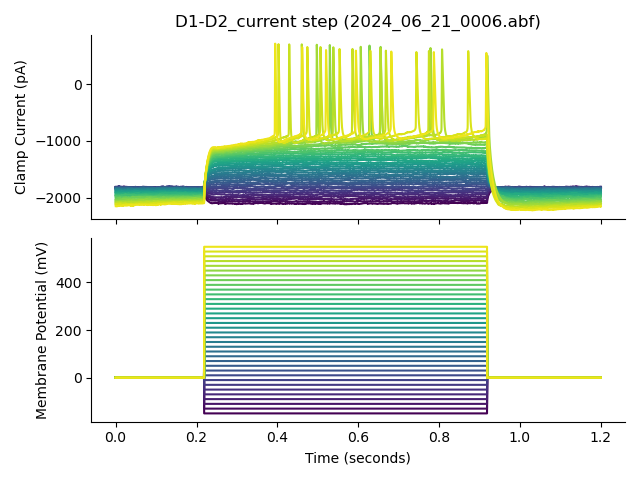

In [6]:
plt.close('all')
f = files[2]
plot_swps(f)

In [43]:
## Extract the sweeps
swps, swp_time, sr = get_sweeps(f)
## The mean on your current step:
i_start = 0.4
i_end = 0.8
current_step = np.mean(swp_window(swps,i_start,i_end,sr,channel=1),axis=1)
## The spiking part:
v_start = 0.22
v_end = 0.9186
voltage = swp_window(swps,v_start,v_end,sr,channel=0)

In [49]:

def kernel(dx, sigma):
    return np.exp(-dx**2/(2*sigma**2))


def smooth(x, sigma, ydata, xdata=None):
    x = np.array(x)
    if xdata is None:
        assert len(x)==np.array(ydata).shape[-1]
        xdata = x
    k = kernel(xdata[:,None]-x[None,:], sigma)
    ydim = np.array(ydata).ndim
    new_shape_k = tuple([1]*(ydim-1)) + k.shape
    k = np.reshape(k,new_shape_k)
    y = (k*ydata[...,None]).sum(-2)/k.sum(-2)
    return y
    
def spike_detect(volt, v_dt,
                 thr=-10, inf_bnd=3, sup_bnd=500,
                 ref_t=1e-3):
    deriv = np.diff(volt)
    is_spk = (deriv[:-1]<20) * (deriv[1:]>=20)
    spikes = np.where(is_spk)[0]
    refact = int(ref_t/v_dt)
    ref = 0
    sspk = []
    for st in spikes:
        if st<ref:
            continue
        else:
            spk = volt[st:st+refact]
        if spk.max() < thr:
            continue
        else:
            sspk.append(st)
            ref = st+refact
    sspk = np.array(sspk)
    stimes = sspk*v_dt
    isi = np.diff(stimes)
    inst_frq = 1/isi
    if sspk.shape == (0,):
        return 0
    else:
        return np.mean(inst_frq)

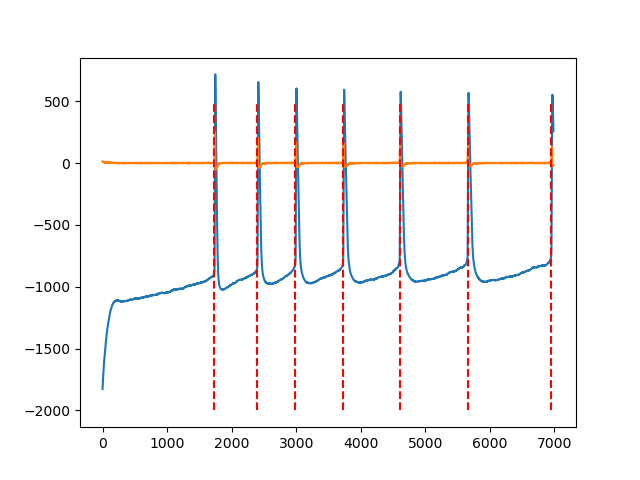

In [51]:
v = voltage[-1]
ref_t=1e-3
thr=-10
v_dt = 1/sr
deriv = np.diff(v)
fig,ax = plt.subplots()
ax.plot(v)
ax.plot(deriv)
is_spk = (deriv[:-1]<20) * (deriv[1:]>=20)
spikes = np.where(is_spk)[0]
stimes = spikes*v_dt
ax.vlines(spikes,-2000,500,color='red',linestyle='dashed')
isi = np.diff(stimes)
inst_frq = 1/isi

In [31]:
spikes

array([ 112,  118,  120, ..., 6942, 6954, 6957])

In [52]:
res = []
for v in voltage:
    res.append(spike_detect(v,1/sr))

/home/alan/miniforge3/envs/CSHL/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alan/miniforge3/envs/CSHL/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [53]:
res

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 nan,
 7.961783439490446,
 7.502602290015212,
 9.331929316428527,
 12.567376812506525,
 9.916482706639952,
 12.68157390623848]

/tmp/ipykernel_15398/1502344618.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


Text(0, 0.5, 'Spiking frequency (Hz)')

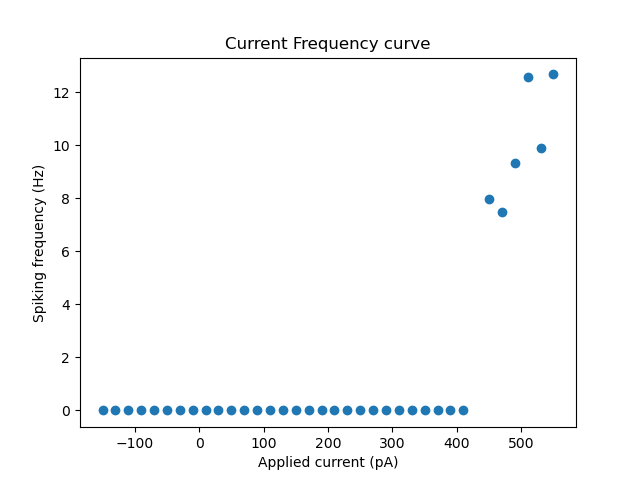

In [54]:
fig,ax = plt.subplots()
ax.set_title('Current Frequency curve')
ax.plot(current_step,res,'o')
ax.set_xlabel('Applied current (pA)')
ax.set_ylabel('Spiking frequency (Hz)')

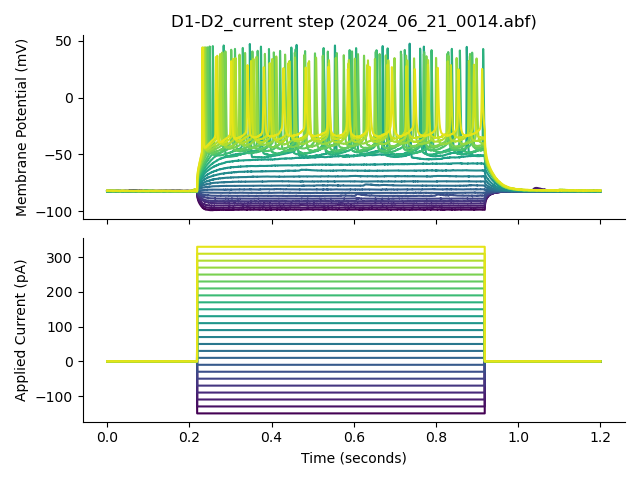

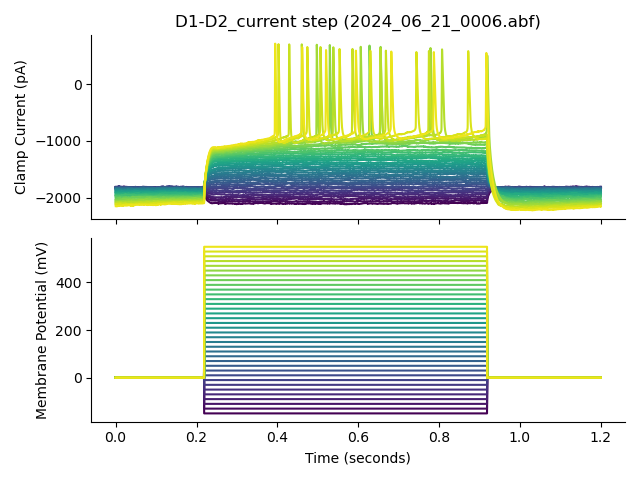

/home/alan/miniforge3/envs/CSHL/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alan/miniforge3/envs/CSHL/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


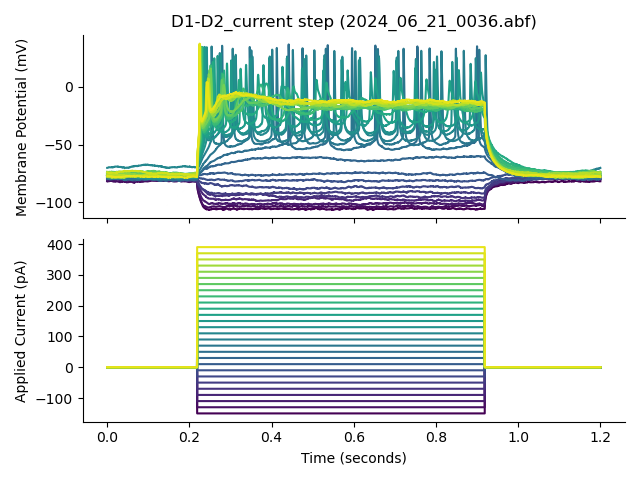

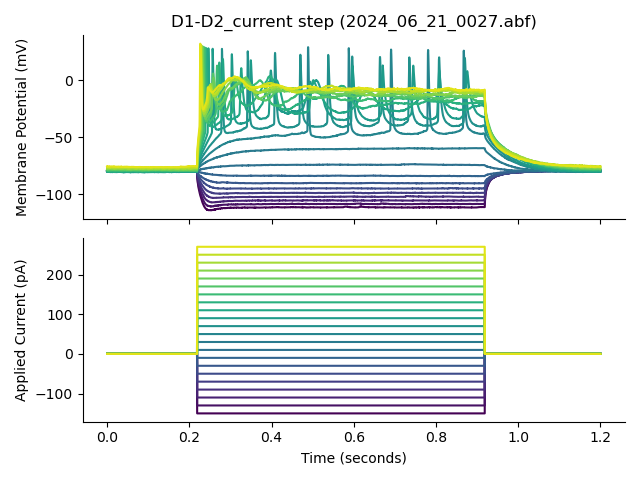

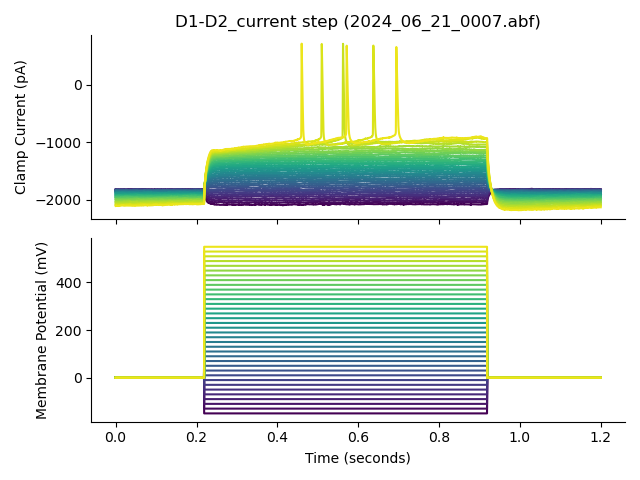

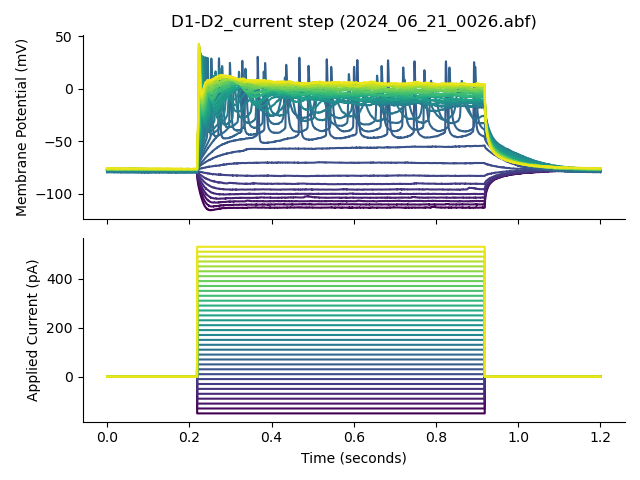

In [68]:
plt.close('all')
cells = []
for f in files[1:]:
    swps, swp_time, sr = get_sweeps(f)
    plot_swps(f)
    ## The mean on your current step:
    i_start = 0.4
    i_end = 0.8
    current_step = np.mean(swp_window(swps,i_start,i_end,sr,channel=1),axis=1)
    ## The spiking part:
    v_start = 0.22
    v_end = 0.9186
    voltage = swp_window(swps,v_start,v_end,sr,channel=0)
    res = []
    for v in voltage:
        res.append(spike_detect(v,1/sr))
    cells.append([current_step,res])

In [67]:
len(cells)

6

(300.0, 600.0)

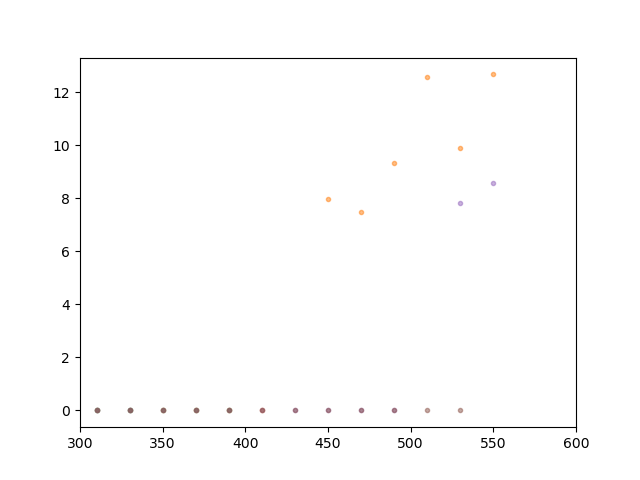

In [65]:
plt.close('all')
fig,ax = plt.subplots()
for c in cells:
    ax.plot(c[0],c[1],'.',alpha=0.5)
ax.set_xlim(300,600)

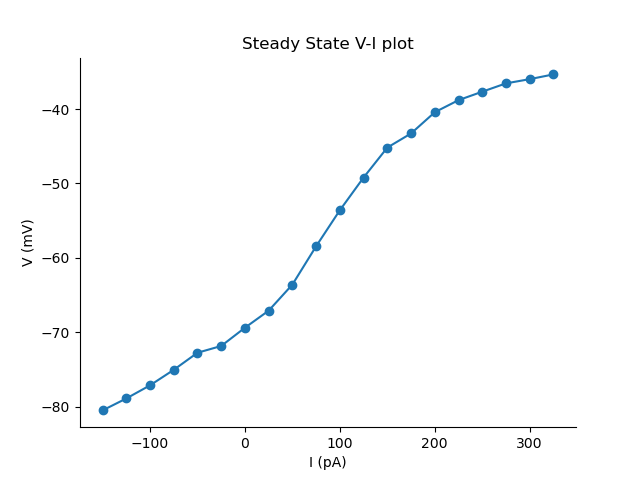

In [61]:
## Extract the sweeps
swps, swp_time, sr = get_sweeps(f)
## The mean on your current step:
i_start = 0.2
i_end = 1
current_step = np.mean(swp_window(swps,i_start,i_end,sr,channel=1),axis=1)
## The spiking part:
v_start = 1
v_end = 1.1
voltage = np.mean(swp_window(swps,v_start,v_end,sr,channel=0),axis=1)
fig,ax = plt.subplots()
ax.set_title('Steady State V-I plot')
ax.plot(current_step,voltage,'-o')
ax.set_ylabel('V (mV)')
ax.set_xlabel('I (pA)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

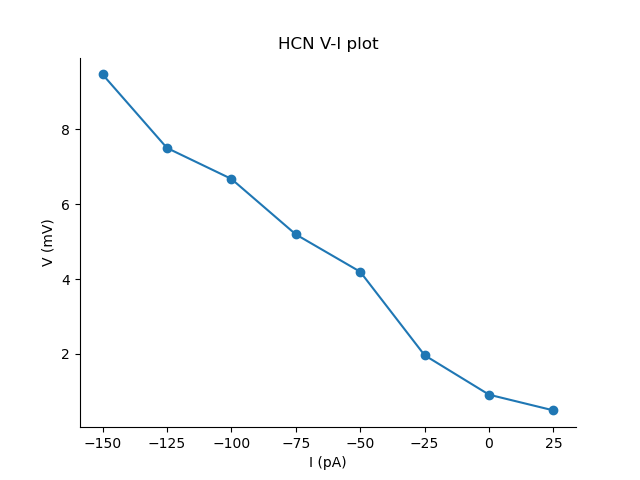

In [64]:
## Extract the sweeps
swps, swp_time, sr = get_sweeps(f)
## The mean on your current step:
i_start = 0.2
i_end = 1
current_step = np.mean(swp_window(swps,i_start,i_end,sr,channel=1),axis=1)
## The base part:
v_start = 1
v_end = 1.1
voltage = np.mean(swp_window(swps,v_start,v_end,sr,channel=0),axis=1)
## The base part:
v_start = 0.2
v_end = 0.6
sag = np.min(swp_window(swps,v_start,v_end,sr,channel=0),axis=1)
hcn = voltage - sag
fig,ax = plt.subplots()
ax.set_title('HCN V-I plot')
ax.plot(current_step[:8],hcn[:8],'-o')
ax.set_ylabel('V (mV)')
ax.set_xlabel('I (pA)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()